# CMB Temperature Map Simulations

## Importing Necessary Modules

This code creates unlensed Q & U maps of the CMB and phi map FFTs which can be used to lens them using QuickLens.

It takes in a CMB spectrum generated by CAMB (https://camb.info/readme.html).

#### Order matters here. The code breaks if you import pymaster after numpy or matplotlib.

In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline
import random

In [2]:
from scipy.interpolate import interp1d
import flat_cmb_sims as fcs

## Defining Map Parameters

In [3]:
# This is the map object that will be used to generate the fake CMB maps
pixels = 192
degrees = 5
fmi = fcs.map_parameters(pixels, degrees, projection="AIR")

## Setting plotting settings

In [4]:
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

## Importing spectrum generated by CAMB

In [5]:
spectra_dict = fcs.load_cmb_spectra("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", fix_scaling=True, add_zeroed=True)

spectra_dict["clTB"] = 0 * spectra_dict["clTT"]
spectra_dict["clBB"] = 0 * spectra_dict["clTT"]
spectra_dict["clEB"] = 0 * spectra_dict["clTT"]

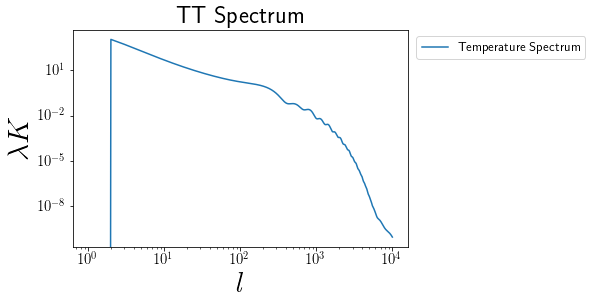

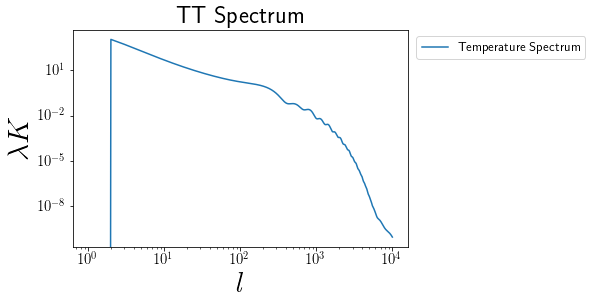

In [6]:
fcs.spectrum_plot(spectra_dict["l modes"], spectra_dict["clTT"], "Temperature Spectrum")

## Test Map Generation

## Generating Simulations

The specific function used is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/master/src/nmt_field_flat.c#L431

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate # of maps to be calculated for each spin and each spectrum (and # of spectra associated)

-Calculate ALMs using fs_synalm:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

-Loop through the ALMs to and convert from the spectra to the map using fs_alm2map:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L220

-Return the maps

The ALMs function is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate maximum achievable l-mode (lmax), set to inv_dkvol (I think, inv_dkvol has the same calculation as my lmax)

-Looping over each pixel and calculating the associated mode in x-, y- directions and their geometric average (overall mode)

-Calculate the associated amplitude given the input spectrum (spectrum is splined, then overall mode fed to spline)

-Calculate "true" spectrum value as 1/2*lmax*input spectrum amplitude (But why is this the value?)

-Generate randomn numbers using rng_gauss, incorporate it using gsl_matrix_set

-Calculate the beam pattern by splining and evaluating inputted beam

-Multiplies the beam pattern against vector containing random numbers, sets this to real and imaginary parts of A

-Setting Alms to these values for different frequency values

-Returns Alms

In [7]:
temperature_map = fcs.generate_maps(spectra_dict, fmi, 1, pixels, temp_only=True, give_seeds=[6])

0


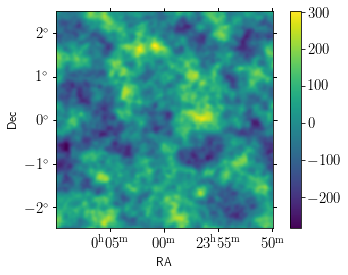

In [8]:
#Demo of randomly generated map
fmi.view_map(temperature_map[0].flatten())

In [9]:
tqu_maps = fcs.generate_maps(spectra_dict, fmi, 1, pixels, TQU_maps=True)
np.shape(tqu_maps)

0


(1, 3, 192, 192)

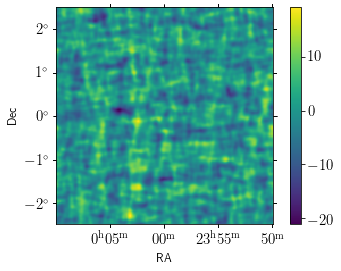

In [10]:
#Demo of randomly generated map
fmi.view_map(tqu_maps[0,1].flatten()) 

In [11]:
teb_maps = fcs.generate_maps(spectra_dict, fmi, 1, pixels, TEB_maps=True)

0


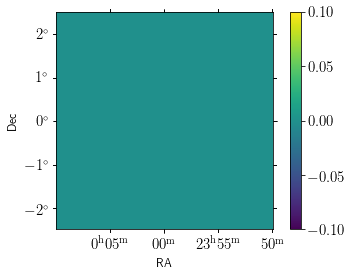

In [12]:
#Demo of randomly generated map
fmi.view_map(teb_maps[0,2].flatten()) 

In [13]:
phi_map = fcs.generate_maps(spectra_dict, fmi, 1, pixels, phi_map=True)

0


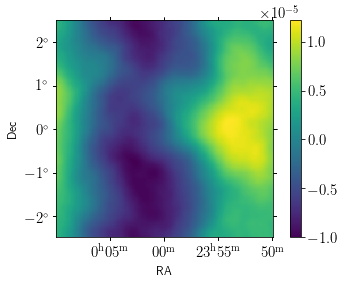

In [14]:
#Demo of randomly generated map
fmi.view_map(phi_map[0].flatten())

## Calculating the Spectrum

### Calculating FFT & Power Spectrum

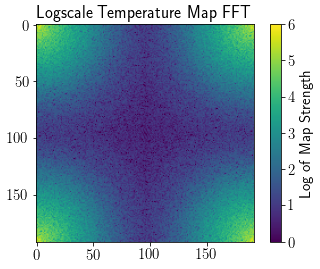

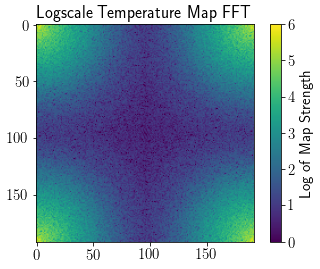

In [15]:
fcs.calculate_and_plot_fft(temperature_map[0,0], "Logscale Temperature Map FFT")

In [16]:
#Calculating the 2D Map Power
map_power_2D = fcs.calculate_map_power_2D(temperature_map[0,0], fmi)

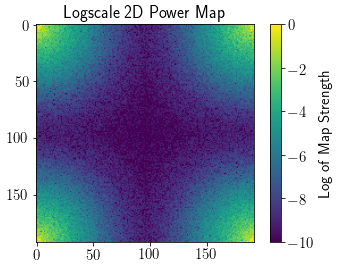

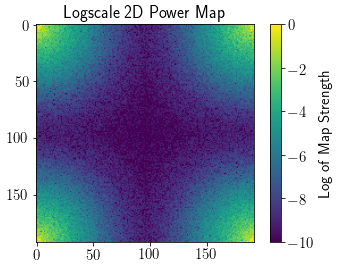

In [17]:
#Plot 2D Map Power
fcs.frequency_domain_plot(map_power_2D,"Logscale 2D Power Map", [-10,0], "Log of Map Strength")

### Summing over each annulus for all four quarters

In [18]:
spectrum = fcs.calculate_power_spectrum(temperature_map[0,0], fmi, method_histogram=False)
joao_spectrum = fcs.calculate_power_spectrum(temperature_map[0,0], fmi, method_histogram=True)

/Users/samanthausman/cmb_research/simcmb/flat_cmb_sims.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  spectra_est[left_bin_edge] += map_power_2D[i,j] #adding power at coordinate (i,j) to bin


/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


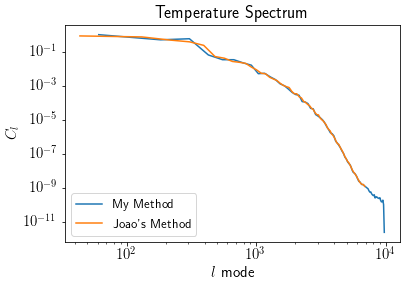

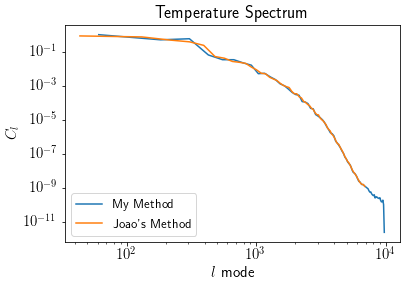

In [19]:
bins = [spectrum[0], joao_spectrum[0]]
spectra = [spectrum[1], joao_spectrum[1]]
labels = ['My Method', "Joao's Method"]

#Approximate spectrum
#Lowest mode is determined by smallest l measurable (determined by bin width (determined by # of bins))
fcs.plot_spectra(bins, spectra, "Temperature Spectrum", labels)

### Plotting estimated spectrum, Comparing to input spectrum

In [20]:
#Spline data to compare input spectrum to estimated spectrum
f1 = interp1d(spectra_dict["l modes"], spectra_dict["clTT"], kind="nearest")
f2 = interp1d(spectrum[0], spectrum[1], kind="nearest")
f3 = interp1d(joao_spectrum[0], joao_spectrum[1], kind="nearest")

/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


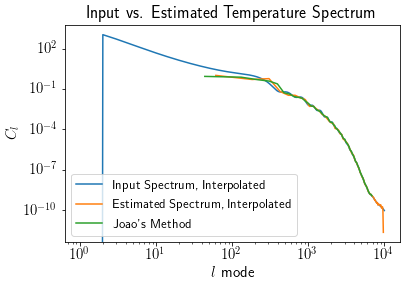

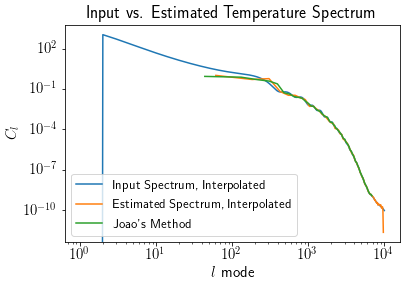

In [21]:
l_mode_list = [spectra_dict["l modes"], spectrum[0], joao_spectrum[0]]
spectra = [f1(spectra_dict["l modes"]), f2(spectrum[0]), f3(joao_spectrum[0])]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated", "Joao's Method"]
fcs.plot_spectra(l_mode_list, spectra, "Input vs. Estimated Temperature Spectrum", labels)

/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


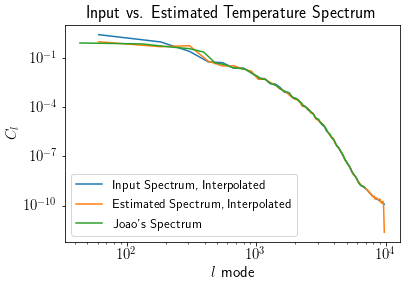

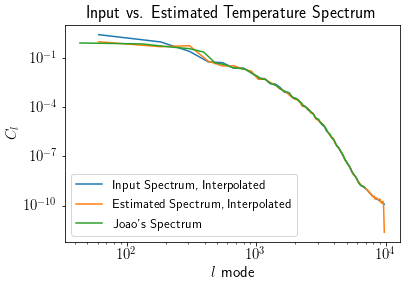

In [22]:
#Zooming in on above plot to domain which both spectra are valid
l_mode_list = [spectrum[0], spectrum[0], joao_spectrum[0]]
spectra = [f1(spectrum[0]), f2(spectrum[0]), f3(joao_spectrum[0])]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated", "Joao's Spectrum"]
fcs.plot_spectra(l_mode_list, spectra, "Input vs. Estimated Temperature Spectrum", labels)